In [2]:
import requests
import json
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

### API request

In [ ]:
url = "https://v3.football.api-sports.io/odds"
params = {'league': 39, 'season': 2023,'date':'2023-12-30'}
headers = {
    'x-rapidapi-host': "v3.football.api-sports.io",
    'x-rapidapi-key': "your-api-key"
}

response = requests.get(url, headers=headers, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    print("Request was successful!")
    # Extract the JSON response
    data = response.json()
    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

    # Save the response data to a file with a timestamp in the filename for unique identification
    filename = f'bets_{timestamp}.json'
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=2)  

elif response.status_code == 404:
    print("Resource not found. Please check the URL.")

# Check if the status code is 401 (Unauthorized)
elif response.status_code == 401:
    print("Unauthorized access. Please check your authentication credentials.")

# Handle the case where the request was not successful (status code is not 200, 404, 401, etc.)
else:
    print(f"Request failed with status code: {response.status_code}")
    print("Response Text:", response.text)  # Print the response text for further inspection

### Opening the nested structure of the JSON

In [12]:
df=data['response']
df=pd.DataFrame(df)
df=pd.json_normalize(json.loads(df.to_json(orient='records')))
df=df.explode('bookmakers')
df=pd.json_normalize(json.loads(df.to_json(orient='records')))
df=df.explode('bookmakers.bets')
df=pd.json_normalize(json.loads(df.to_json(orient='records')))
df=df.explode('bookmakers.bets.values')
df=pd.json_normalize(json.loads(df.to_json(orient='records')))
df.head()

,update,league.id,league.name,league.country,league.logo,league.flag,league.season,fixture.id,fixture.timezone,fixture.date,fixture.timestamp,bookmakers.id,bookmakers.name,bookmakers.bets.id,bookmakers.bets.name,bookmakers.bets.values.value,bookmakers.bets.values.odd
0,2023-12-30T12:00:51+00:00,39,Premier League,England,https://media-4.api-sports.io/football/leagues...,https://media-4.api-sports.io/flags/gb.svg,2023,1035365,UTC,2023-12-30T15:00:00+00:00,1703948400,6,Bwin,1,Match Winner,Home,2.20
1,2023-12-30T12:00:51+00:00,39,Premier League,England,https://media-4.api-sports.io/football/leagues...,https://media-4.api-sports.io/flags/gb.svg,2023,1035365,UTC,2023-12-30T15:00:00+00:00,1703948400,6,Bwin,1,Match Winner,Draw,3.20
2,2023-12-30T12:00:51+00:00,39,Premier League,England,https://media-4.api-sports.io/football/leagues...,https://media-4.api-sports.io/flags/gb.svg,2023,1035365,UTC,2023-12-30T15:00:00+00:00,1703948400,6,Bwin,1,Match Winner,Away,3.40
3,2023-12-30T12:00:51+00:00,39,Premier League,England,https://media-4.api-sports.io/football/leagues...,https://media-4.api-sports.io/flags/gb.svg,2023,1035365,UTC,2023-12-30T15:00:00+00:00,1703948400,6,Bwin,2,Home/Away,Home,1.52
4,2023-12-30T12:00:51+00:00,39,Premier League,England,https://media-4.api-sports.io/football/leagues...,https://media-4.api-sports.io/flags/gb.svg,2023,1035365,UTC,2023-12-30T15:00:00+00:00,1703948400,6,Bwin,2,Home/Away,Away,2.35


### Data Processing
- removing unnecessary columns and renaming the remaining ones

In [13]:
df.drop(['update','league.id','league.name','league.country',
         'league.logo','league.flag','league.season','fixture.date',
         'fixture.timezone','fixture.timestamp'],
          axis=1,inplace=True)

df.rename(columns={'fixture.id':'fixture_id',
                   'bookmakers.name':'bookmaker',
                   'bookmakers.id':'bookmaker_id',
                   'bookmakers.bets.id':'bet_id',
                   'bookmakers.bets.name':'bet_type',
                   'bookmakers.bets.values.value':'bet_outcome',
                   'bookmakers.bets.values.odd':'odds'},
                    inplace=True)

### Data Exploration

In [186]:
print(f'There are {df.shape[0]} bets in the datset.')
print(f'There are {df.bookmaker.nunique()} bookmakers represented in the dataset:')
pd.DataFrame(df.bookmaker.unique())                                                                      

There are 29798 bets in the datset.
There are 19 bookmakers represented in the dataset:


,0
0,Bwin
1,NordicBet
2,10Bet
3,William Hill
4,Bet365
5,Marathonbet
6,Unibet
7,Betfair
8,Betsson
9,188Bet


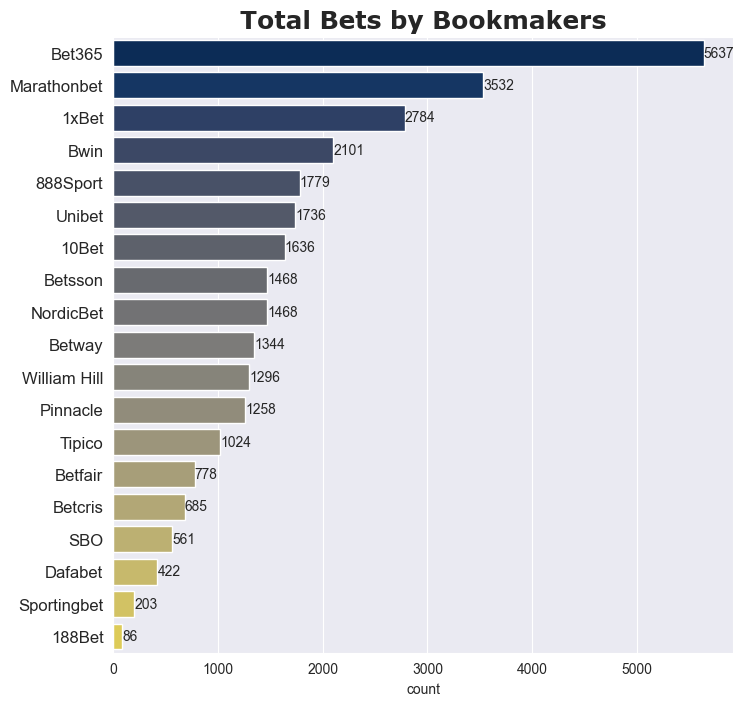

In [24]:
total_bets = df['bookmaker'].value_counts().reset_index()

plt.figure(figsize=(8, 8))
sns.set_style('darkgrid')
ax=sns.barplot(x='count', y='bookmaker',data=total_bets, palette='cividis',hue='bookmaker')
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
                va='center')
plt.ylabel(None)
plt.title('Total Bets by Bookmakers',fontdict={'fontsize':18,'fontweight':'bold','fontfamily':'Verdana'})
ax.tick_params(axis='y', labelsize=12)
plt.show()

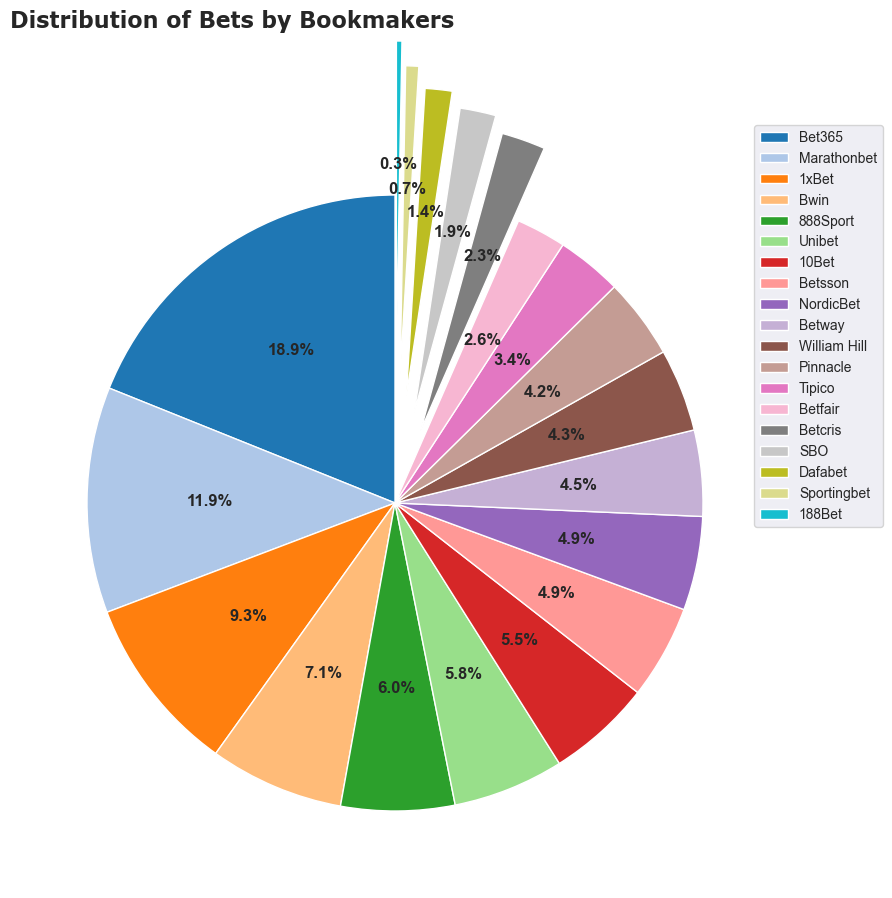

In [28]:
total_bets2 = df['bookmaker'].value_counts()

plt.figure(figsize=(10, 10))
sns.set_palette(sns.color_palette("tab20"))
explode = (0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0.3,0.35,0.42,0.5)
plt.pie(x=total_bets2.values,labels=total_bets2.index,autopct='%1.1f%%',startangle=90,
        labeldistance=None,explode=explode,textprops={'fontsize':12,'fontweight':'bold'})
plt.title('Distribution of Bets by Bookmakers', loc='left',pad=65,
          fontdict={'fontsize':16,'fontweight':'bold','fontfamily':'Verdana'})
plt.legend(title=None, bbox_to_anchor=(1.05, 1), loc='upper center')

plt.show()

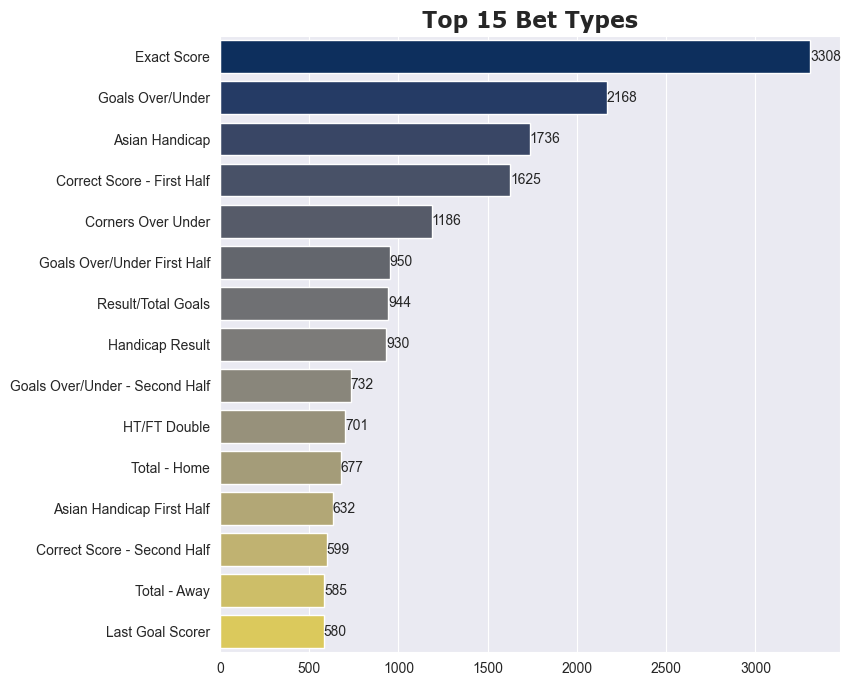

In [33]:
type_count = df['bet_type'].value_counts().reset_index().head(15)

plt.figure(figsize=(8, 8))
ax=sns.barplot(x='count', y='bet_type',data=type_count,palette='cividis',hue='bet_type')
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', (p.get_width(),p.get_y() + p.get_height()/2),
                va='center')
plt.title('Top 15 Bet Types',fontdict={'fontsize':16,'fontweight':'bold','fontfamily':'Verdana'})
plt.ylabel(None)
plt.xlabel(None)
plt.show()

In [67]:
over=df.query('bet_outcome == "Yes" & bet_type == "Both Teams Score"')
over = over.groupby(['fixture_id', 'bookmaker', 'odds']).size().reset_index()
over.drop(columns=0,inplace=True)
over

,fixture_id,bookmaker,odds
0,1035364,10Bet,1.62
1,1035364,188Bet,1.71
2,1035364,1xBet,1.70
3,1035364,888Sport,1.76
4,1035364,Bet365,1.70
...,...,...,...
97,1035373,Pinnacle,1.78
98,1035373,Sportingbet,1.70
99,1035373,Tipico,1.65
100,1035373,Unibet,1.74


In [68]:
over=over.pivot(index='bookmaker', columns='fixture_id', values='odds')
over

fixture_id,1035364,1035365,1035368,1035369,1035370,1035373
bookmaker,,,,,,
10Bet,1.62,1.80,1.57,2.55,1.50,1.67
188Bet,1.71,1.88,1.66,2.85,1.57,1.77
1xBet,1.70,1.88,1.66,2.74,1.57,1.76
888Sport,1.76,1.91,1.68,2.48,1.61,1.74
Bet365,1.70,1.95,1.67,2.63,1.57,1.75
Betcris,1.70,1.90,1.68,2.65,1.58,1.75
Betfair,1.77,1.98,1.73,2.90,1.67,1.82
Betsson,1.70,1.90,1.64,2.77,1.57,1.76
Betway,1.70,1.88,1.67,2.70,1.60,1.75


In [69]:
over=over[over.columns].rank(method='dense',ascending=False,na_option='bottom')
over

fixture_id,1035364,1035365,1035368,1035369,1035370,1035373
bookmaker,,,,,,
10Bet,7.0,7.0,9.0,11.0,8.0,9.0
188Bet,4.0,5.0,5.0,3.0,5.0,3.0
1xBet,5.0,5.0,5.0,6.0,5.0,4.0
888Sport,2.0,3.0,3.0,12.0,2.0,6.0
Bet365,5.0,2.0,4.0,9.0,5.0,5.0
Betcris,5.0,4.0,3.0,8.0,4.0,5.0
Betfair,1.0,1.0,1.0,2.0,1.0,1.0
Betsson,5.0,4.0,7.0,4.0,5.0,4.0
Betway,5.0,5.0,4.0,7.0,3.0,5.0


In [189]:
over[over.columns].sum(axis=1).sort_values().rank(method='min').astype('int')

bookmaker
Betfair          1
Pinnacle         2
188Bet           3
888Sport         4
Unibet           4
Betway           6
Betcris          6
Betsson          6
NordicBet        6
1xBet           10
Bet365          10
Marathonbet     10
Bwin            13
Sportingbet     13
William Hill    15
10Bet           16
Tipico          17
dtype: int32

In [133]:
import pandas as pd

def ranking_function(df, *bet_types):
    # Convert bet_types to a flat list
    bet_types = [item for sublist in bet_types for item in (sublist if isinstance(sublist, list) else [sublist])]

    # Get unique fixture IDs from the dataframe
    fixture_ids = df['fixture_id'].unique()

    result_data = {}

    for bet_type_name in bet_types:
        # Filter the DataFrame for the specified bet type and fixture IDs
        filtered_df = df[(df['bet_type'] == bet_type_name) & (df['fixture_id'].isin(fixture_ids))]

        # Get unique bet outcomes for the specified bet type
        bet_outcomes = filtered_df['bet_outcome'].unique()

        for bet_outcome in bet_outcomes:
            # Filter by both bet type and outcome
            filtered_data = filtered_df[filtered_df['bet_outcome'] == bet_outcome]
            
            # Check if the filtered dataframe is empty
            if not filtered_data.empty:
                # Group by relevant columns and calculate ranks
                grouped_df = filtered_data.groupby(['fixture_id', 'bookmaker', 'odds']).size().reset_index()
                grouped_df.drop(columns=0, inplace=True)

                # Use pivot_table
                pivot_df = grouped_df.pivot_table(index='bookmaker', columns='fixture_id', values='odds',aggfunc='min')

                # Calculate ranks
                rank_df = pivot_df[pivot_df.columns].rank(method='dense', ascending=False, na_option='bottom')
                sum_rank_df = rank_df[rank_df.columns].sum(axis=1).sort_values().rank(method='dense').astype(int).reset_index(name='rank')

                # Store the results for this bet outcome
                result_data.setdefault(bet_type_name, {})[bet_outcome] = {
                    'grouped_df': grouped_df,
                    'pivot_df': pivot_df,
                    'sum_rank_df': sum_rank_df
                }

                # Print the results directly
                print(f"Bet Type: {bet_type_name}")
                print(f"Odds for {bet_type_name} {bet_outcome}")
                print()
                print(pivot_df)
                print()
                print(sum_rank_df)
                print("=" * 60)

# Example usage with a single bet type


# Example usage with a list of bet types
ranking_function(df, 'Match Winner','Asian Handicap')


Bet Type: Match Winner
Odds for Match Winner Home

fixture_id   1035364 1035365 1035368 1035369 1035370 1035373
bookmaker                                                   
10Bet           1.44    2.20    5.25    1.07    3.10    2.75
188Bet          1.44    2.19    5.50    1.08    3.15    2.72
1xBet           1.48    2.25    5.50    1.08    3.34    2.79
888Sport        1.40    2.17    5.40    1.06    3.20    2.65
Bet365          1.44    2.15    5.25    1.07    3.10    2.70
Betcris         1.41    2.12    5.15    1.06    3.00    2.63
Betfair         1.44    2.26    5.90    1.09    3.25    2.84
Betsson         1.44    2.25    5.60    1.07    3.10    2.72
Betway          1.44    2.20    5.00    1.07    3.10    2.70
Bwin            1.43    2.20    5.25    1.07    3.10    2.70
Dafabet         1.43    2.19    5.30    1.07    3.05    2.70
Marathonbet     1.44    2.19    5.35    1.07    3.24    2.71
NordicBet       1.44    2.25    5.60    1.07    3.10    2.72
Pinnacle        1.44    2.23    5.